# Flatten model template

Simple flatten model for bot detection.

## Initialization

Import needed packages, initialize model parameters and configure folder and file paths.

### Imports

Import necessary python packages.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv
import shutil

from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import preprocessing, models, layers, callbacks
from mlxtend.plotting import plot_confusion_matrix

Using TensorFlow backend.


### Parameters initialization

Initialize model parameters, file and folder used by the model.

#### Model parameters

Initialize model related parameters. 

Increment the model version with every change of the model configuration. This will result in the tokenizer, and model version being saved in a seperate files that can be later loaded and reused/re-evaluated. To test and evaluate an already trained model version, change the version parameter and skip to section 4: Model Validation. 

Don't forget to commit the model to git after each version increment, this way the state of the notebook that was used to train the given model version can be easily reverted to.

The `template_version` variable represents the version of the template notebook used as a base for this model.

train_data_csv and test_data_csv point to the location of the processed training and test datasets used to train and validate the model.

training_data:
* 0.7: social honeypot dataset
* 0.8: fake project dataset
* 0.9: combined dataset

In [2]:
# model information
model_name = 'bot_detection_flatten'
model_version = '0.1'
train_data_version = '0.1'
template_version = '1.5'

# model parameters
max_features = 50000
max_words = 50
batch_size = 512
embedding_dimensions = 200
dense_size = 128
epochs = 20

# file and folder locations

#social honeypot datasets
train_data_social_honeypot_csv = '../../data/interim/bot_sentiment/social_honeypot_train_sentiment.csv'
test_data_social_honeypot_csv = '../../data/interim/bot_sentiment/social_honeypot_test_sentiment.csv'

#fake project datasets
train_data_fake_set_csv = '../../data/interim/bot_sentiment/fake_project_train_sentiment.csv'
test_data_fake_set_csv = '../../data/interim/bot_sentiment/fake_project_test_sentiment.csv'

# set to true to combine the 2 datasets
combined = False

# dataset in use
train_data_csv = train_data_social_honeypot_csv
test_data_csv = test_data_social_honeypot_csv

models_folder = '../../models'
processed_data_folder = '../../data/processed/'

#### File and folder names

Initialize file and folder names.


`tensorboard_base_log_folder` is the base tensorboard log folder under which every version of the model will create its own log folder which is defined by the `tensorboard_current_log_folder` variable. This way tensorboard can be launched pointing to the base log folder and can be used to compare differences between the different versions of the model.

In [3]:
# model folder and model file
model_folder = os.path.join(models_folder, model_name)
model_file = os.path.join(model_folder,
                          model_name + '_' + model_version + '.h5')

# training data and tokenizer
tokenizer_file = os.path.join(model_folder,
                              'tokenizer_' + train_data_version + '.pickle')

# tensor board log folders
tensorboard_base_log_folder = os.path.join(model_folder, 'tensor_logs')
tensorboard_current_log_folder = os.path.join(tensorboard_base_log_folder,
                                              'v' + model_version)

# embeddings metdata file
embeddings_metadata_tsv_filename = 'embeddings_metadata_' + \
    train_data_version + '.tsv'
tensoboard_embedddings_path = os.path.join('..', '..',
                                           embeddings_metadata_tsv_filename)
embeddings_metadata_tsv = os.path.join(model_folder,
                                       embeddings_metadata_tsv_filename)

# interim training data files
train_data_file = processed_data_folder + model_name + \
    '_train_data_' + train_data_version + '.npy'
train_labels_file = processed_data_folder + model_name + \
    '_train_labels_' + train_data_version + '.npy'
validation_data_file = processed_data_folder + model_name + \
    '_validation_data_' + train_data_version + '.npy'
validation_labels_file = processed_data_folder + model_name + \
    '_validation_labels_' + train_data_version + '.npy'

# create model folder if it doesn't exist
os.makedirs(model_folder, exist_ok=True)

## Prepare training data

Intialize folders, load the training dataset from disk, initialize the keras tokenizer, generate word vectors out of the texts from the training dataset and split the training dataset into a training and validation set.

### Load training dataset

Load the training dataset from disk and convert all texts to strings.

In [4]:
if combined is True:
    df_train = pd.read_csv(train_data_social_honeypot_csv)
    df_fake_set_train = pd.read_csv(train_data_fake_set_csv)
    df_train = df_train.append(df_fake_set_train)
else:
    df_train = pd.read_csv(train_data_csv)

df_train.text = df_train.text.astype(str)

### Initialize tokenizer

Initialize a keras tokenizer instance from disk using the `max_features` variable to define the size of the vocabulary to use for training, then serialize the fitted tokenizer to disk for later use.

In [5]:
tokenizer = preprocessing.text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_train.text)

# pickle tokenizer instance to disk
with open(tokenizer_file, 'wb') as file:
    pickle.dump(tokenizer, file, protocol=pickle.HIGHEST_PROTOCOL)

### Create metadata file

Create a tsv(tab separated values) metadata file containing the vocabulary used for the embedding layer.

More info @ https://www.tensorflow.org/guide/embedding#metadata

In [6]:
word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

with open(embeddings_metadata_tsv, 'w') as file:
    for i in range(1, max_features + 1):
        file.write(word_index[i] + "\n")

### Generate word vectors

assign the type array to the `train_labels` variable, generate sequences out of the training texts using the keras tokenizer and create word vectors to be used for training out of them which are then assigned to the `train_data` variale.

In [7]:
train_labels=df_train.type
train_tokenized_text = tokenizer.texts_to_sequences(df_train.text)
train_data = preprocessing.sequence.pad_sequences(train_tokenized_text, maxlen=max_words)

### Split training dataset

Split the training data set into a training and validation sets, both for the word vectors and the labels.

In [8]:
x_train, x_val, y_train, y_val = train_test_split(train_data,
                                                  train_labels,
                                                  test_size=40000)

### Save training data

Save training word vectors and labels to disk

In [9]:
np.save(train_data_file, x_train)
np.save(train_labels_file, y_train)
np.save(validation_data_file, x_val)
np.save(validation_labels_file, y_val)

## Model Training

Define the model using keras, fit it using the training dataset and display statistics about the training process.

### load training data from disk

Load training word vectors and labels from disk

In [10]:
x_train = np.load(train_data_file)
y_train = np.load(train_labels_file)
x_val = np.load(validation_data_file)
y_val = np.load(validation_labels_file)

### Model definition

Define the model to train using the keras API

initialize common parameters in section 1.2.1: Model parameters.

In [15]:
model = models.Sequential(name=model_name)
model.add(layers.Embedding(max_features, embedding_dimensions, input_length=len(x_train[0]), name='embedding'))
model.add(layers.Flatten())
model.add(layers.Dense(dense_size, activation='relu', name='dense'))
model.add(layers.Dense(1, activation='sigmoid', name='output'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc']) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 200)           10000000  
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1280128   
_________________________________________________________________
output (Dense)               (None, 1)                 129       
Total params: 11,280,257
Trainable params: 11,280,257
Non-trainable params: 0
_________________________________________________________________


### Callbacks

Define the following callbacks:

* Early stopping if the model's validation loss hasn't improved for 4 epochs
* Model checkpoint that saves the best performing iteration to `model_file` based on validation loss
* Tensorboard with histograms and embedding. Note in order to visualize the weights instead of the output of the embedding layer I had to revert the following keras pull request:
https://github.com/keras-team/keras/pull/7766

In [16]:
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
    ),
    callbacks.ModelCheckpoint(
        filepath=model_file,
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.TensorBoard(log_dir=tensorboard_current_log_folder,
                          histogram_freq=1,
                          batch_size=batch_size,
                          embeddings_freq=1,
                          embeddings_layer_names=['embedding'],
                          embeddings_metadata=tensoboard_embedddings_path)
]

### Tensorboard

Delete and recreate the tensorboard folder for the current version and run tensorboard on the base log folder.

In [17]:
shutil.rmtree(tensorboard_current_log_folder, ignore_errors=True)
os.makedirs(tensorboard_current_log_folder, exist_ok=True)

# %reload_ext tensorboard.notebook
# %tensorboard --logdir {tensorboard_base_log_folder}

### Fit model

Fit the model on the training dataset

In [18]:
history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks_list,
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 5136400 samples, validate on 40000 samples
Epoch 1/20
5136400/5136400 [==============================] - 58s 11us/step - loss: 0.4213 - acc: 0.8151 - val_loss: 0.4044 - val_acc: 0.8247
Epoch 2/20
5136400/5136400 [==============================] - 58s 11us/step - loss: 0.3713 - acc: 0.8392 - val_loss: 0.4010 - val_acc: 0.8290
Epoch 3/20
5136400/5136400 [==============================] - 58s 11us/step - loss: 0.3273 - acc: 0.8597 - val_loss: 0.4223 - val_acc: 0.8258
Epoch 4/20
5136400/5136400 [==============================] - 58s 11us/step - loss: 0.2855 - acc: 0.8791 - val_loss: 0.4636 - val_acc: 0.8182
Epoch 5/20
5136400/5136400 [==============================] - 58s 11us/step - loss: 0.2492 - acc: 0.8956 - val_loss: 0.5325 - val_acc: 0.8155


### Model statistics

Generate loss and accuracy charts.

#### Initialize history parameters

Initialize parameters needed for the accuracy and validation charts

In [19]:
%matplotlib inline

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy_values = history_dict['acc']
val_accuracy_values = history_dict['val_acc']
epochs_list = range(1, len(loss_values) + 1)

#### Loss

Plot the training and validation loss.

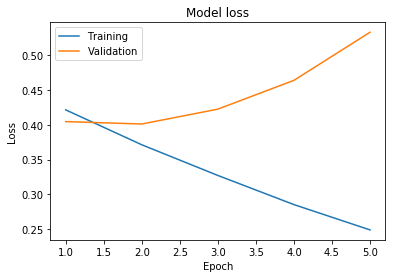

In [20]:
plt.plot(epochs_list, loss_values)
plt.plot(epochs_list, val_loss_values)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show()

#### Accuracy

Plot the training and validation accuracy

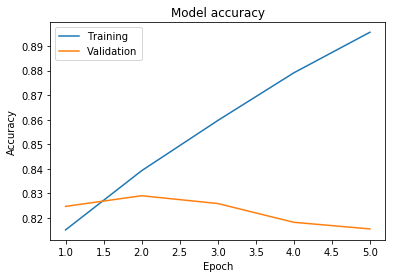

In [21]:
plt.plot(epochs_list, accuracy_values)
plt.plot(epochs_list, val_accuracy_values)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show()

## Model validation

Verify the model's performance.

### Load model

Load the pretrained model, tokenizer and test dataset.

#### Load model from disk

Load the model from disk

In [22]:
model = models.load_model(model_file)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 200)           10000000  
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1280128   
_________________________________________________________________
output (Dense)               (None, 1)                 129       
Total params: 11,280,257
Trainable params: 11,280,257
Non-trainable params: 0
_________________________________________________________________


#### Load tokenizer from disk

Load the prefitted tokenizer form disk

In [23]:
with open(tokenizer_file, 'rb') as file:
    tokenizer = pickle.load(file)

#### Load test dataset

Load the test dataset and convert it to word vectors

In [24]:
if combined is True:
    df_test = pd.read_csv(test_data_social_honeypot_csv)
    df_fake_set_test = pd.read_csv(test_data_fake_set_csv)
    df_test = df_test.append(df_fake_set_test)
else:
    df_test = pd.read_csv(test_data_csv)    

df_test.text = df_test.text.astype(str)

# tokenize, vectorize and pad test texts
test_labels = df_test.type
test_tokenized_text = tokenizer.texts_to_sequences(df_test.text)
test_data = preprocessing.sequence.pad_sequences(test_tokenized_text, maxlen=max_words)

### Test model

Verify the model's performance against the test datasets and test it with example phrases

#### Test dataset test

Evaluate the model against the test dataset.

In [25]:
test_predict_classes = model.predict_classes(test_data)

##### Test Metrics

Calculate and display the evaluation metrics for the test dataset.

In [26]:
accuracy = metrics.accuracy_score(test_labels, test_predict_classes)
precision = metrics.precision_score(test_labels, test_predict_classes)
recall = metrics.recall_score(test_labels, test_predict_classes)
f1 = metrics.f1_score(test_labels, test_predict_classes)
roc_auc = metrics.roc_auc_score(test_labels, test_predict_classes)
cohen_kappa = metrics.cohen_kappa_score(test_labels, test_predict_classes)

print('Accuracy:\t{:.2%}'.format(accuracy))
print('Precision:\t{:.2%}'.format(precision))
print('Recall:\t\t{:.2%}'.format(recall))
print('F1:\t\t{:.2%}'.format(f1))
print('ROC AUC:\t{:.2%}'.format(roc_auc))
print('Cohen\'s kappa:\t{:.2%}'.format(cohen_kappa))

Accuracy:	81.64%
Precision:	88.63%
Recall:		74.78%
F1:		81.11%
ROC AUC:	82.04%
Cohen's kappa:	63.50%


#####  Test Confusion Matrix

Calculate and display the confusion matrix for the test dataset.

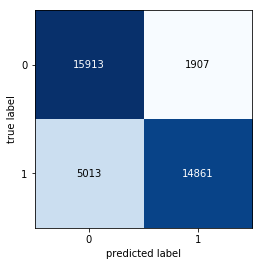

In [27]:
confusion_matrix = metrics.confusion_matrix(test_labels, test_predict_classes)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix)
plt.show()

#### Sample predictions

Define a predict function and test the model on a few sample sentences.

##### Predict function

Define a helper function that takes a string and returns a probability of it being generated by a bot.

In [28]:
def predict(text):
    sequence = tokenizer.texts_to_sequences([text])
    word_vector = preprocessing.sequence.pad_sequences(sequence, maxlen=max_words)
    prediction = model.predict(word_vector)
    return '{:.2%}'.format((prediction)[0][0])

##### Sample predictions

Run the model on a sample of phrases to validate the model's performance on messages that a spam bot can use and those used by humans in everyday speech.

In [29]:
phrases = [
    "Check out this page", 
    "You can read all about our new product here",
    "I just had a super tasty pizza",
    "follow us on twitter",
    "Yesterday was awfully bad",
    "Make money by sitting at home",
    "Tell me something I don’t know",
    "Click here to win a free gift"
]

df_phrases_bot_detection = pd.DataFrame(phrases, columns=['phrases'])
df_phrases_bot_detection['bot_probability'] = df_phrases_bot_detection.phrases.map(predict)

df_phrases_bot_detection

,phrases,bot_probability
0,Check out this page,59.64%
1,You can read all about our new product here,83.75%
2,I just had a super tasty pizza,18.53%
3,follow us on twitter,64.16%
4,Yesterday was awfully bad,8.31%
5,Make money by sitting at home,69.52%
6,Tell me something I don’t know,17.07%
7,Click here to win a free gift,73.51%
